<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Tackling an NLP Problem with Naive Bayes
_Author: Matt Brems_

----

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we are going to apply a **new** modeling technique to natural language processing data.

> "But how can we apply a modeling technique we haven't learned?!"

The DSI program is great - but we can't teach you *everything* about data science in 12 weeks! This lab is designed to help you start learning something new without it being taught in a formal lesson. 
- Later in the cohort (like for your capstone!), you'll be exploring models, libraries, and resources that you haven't been explicitly taught.
- After the program, you'll want to continue developing your skills. Being comfortable with documentation and being confident in your ability to read something new and decide whether or not it is an appropriate method for the problem you're trying to solve is **incredibly** valuable.

### Step 1: Define the problem.

Many organizations have a substantial interest in classifying users of their product into groups. Some examples:
- A company that serves as a marketplace may want to predict who is likely to purchase a certain type of product on their platform, like books, cars, or food.
- An application developer may want to identify which individuals are willing to pay money for "bonus features" or to upgrade their app.
- A social media organization may want to identify who generates the highest rate of content that later goes "viral."

### Summary
In this lab, you're an engineer for Facebook. In recent years, the organization Cambridge Analytica gained worldwide notoriety for its use of Facebook data in an attempt to sway electoral outcomes.

Cambridge Analytica, an organization staffed with lots of Ph.D. researchers, used the Big5 personality groupings (also called OCEAN) to group people into one of 32 different groups.
- The five qualities measured by this personality assessment are:
    - **O**penness
    - **C**onscientiousness
    - **E**xtroversion
    - **A**greeableness
    - **N**euroticism
- Each person could be classified as "Yes" or "No" for each of the five qualities.
- This makes for 32 different potential combinations of qualities. ($2^5 = 32$)
- You don't have to check it out, but if you want to learn more about this personality assessment, head to [the Wikipedia page](https://en.wikipedia.org/wiki/Big_Five_personality_traits).
- There's also [a short (3-4 pages) academic paper describing part of this approach](./celli-al_wcpr13.pdf).

Cambridge Analytica's methodology was, roughly, the following:
- Gather a large amount of data from Facebook.
- Use this data to predict an individual's Big5 personality "grouping."
- Design political advertisements that would be particularly effective to that particular "grouping." (For example, are certain advertisements particularly effective toward people with specific personality traits?)

You want to know the **real-world problem**: "Is what Cambridge Analytica attempted to do actually possible, or is it junk science?"

However, we'll solve the related **data science problem**: "Are one's Facebook statuses predictive of whether or not one is agreeable?"
> Note: If Facebook statuses aren't predictive of one being agreeable (one of the OCEAN qualities), then Cambridge Analytica's approach won't work very well!

### Step 2: Obtain the data.

Obviously, there are plenty of opportunities to discuss the ethics surrounding this particular issue... so let's do that.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model improvment
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [2]:
data = pd.read_csv('./mypersonality_final.csv', encoding = 'ISO-8859-1')

In [3]:
data.head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,NETWORKSIZE,BETWEENNESS,NBETWEENNESS,DENSITY,BROKERAGE,NBROKERAGE,TRANSITIVITY
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she ca...,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
2,b7b7764cfa1c523e4e93ab2a79a946c4,is sore and wants the knot of muscles at the b...,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/22/09 04:48 AM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/20/09 02:31 AM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1


**1. What is the difference between anonymity and confidentiality? All else held equal, which tends to keep people safer?**

In [4]:
# These topics are about how respondees were collected personal information.
# The difference is...
# Anonymity: Data will not contain all of personal information, 
# so data user will not know who are contained in te dataset

# While confientiality is that data users will know personal information of respondees but
# will not reveal to public. To avoid publishing personal information, data users will report data as
# aggregation or they can encode respondees' personal data. For example, #AUTHID this lab's dataset.

# However, encoding personal information is not the safest way of protecting personal information.
# Other data users still can try to decode it. Thus, anonymity will be a better way to protect
# both privacy of data respondess and ones who use data to make analyses.

**2. Suppose that the "unique identifier" in the above data, the `#AUTHID`, is a randomly generated key so that it can never be connected back to the original poster. Have we guaranteed anonymity here? Why or why not?**

In [5]:
# In my opinion, There still be some concerns that personal information will be revealed. 
# Even the UID were randomly generated key but the same key ID key can show user's behavior if not only one datum existing for one key.
# Multiple data for one unique ID let data user extract some informations that might lead to personal identity.

**3. As an engineer for Facebook, you recognize that user data will be used by Facebook and by other organizations - that won't change. However, what are at least three recommendations you would bring to your manager to improve how data is used and shared? Be as specific as you can.**

In [6]:
# 1. Provide data via API to avoid anybody scrapping data and use inappropriately.
# 1. All anonymity should be removed to be sure that Facebook users will be safe for their privacy.
# 2. All all posts that provided from API should be truncated all of personal information. 

### Step 3: Explore the data.

- Note: For our $X$ variable, we will only use the `STATUS` variable. For our $Y$ variable, we will only use the `cAGR` variable.

**4. Explore the data here.**
> We aren't explicitly asking you to do specific EDA here, but what EDA would you generally do with this data? Do the EDA you usually would, especially if you know what the goal of this analysis is.

In [7]:
data.head(1)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,NETWORKSIZE,BETWEENNESS,NBETWEENNESS,DENSITY,BROKERAGE,NBROKERAGE,TRANSITIVITY
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1


In [8]:
# Tokenize data by CountVectorizer
cvec = CountVectorizer(stop_words='english')

data_token = cvec.fit_transform(data['STATUS'])

data_token_df = pd.DataFrame(data_token.todense(),
                            columns=cvec.get_feature_names_out())

data_token_df['cAGR'] = data['cAGR']

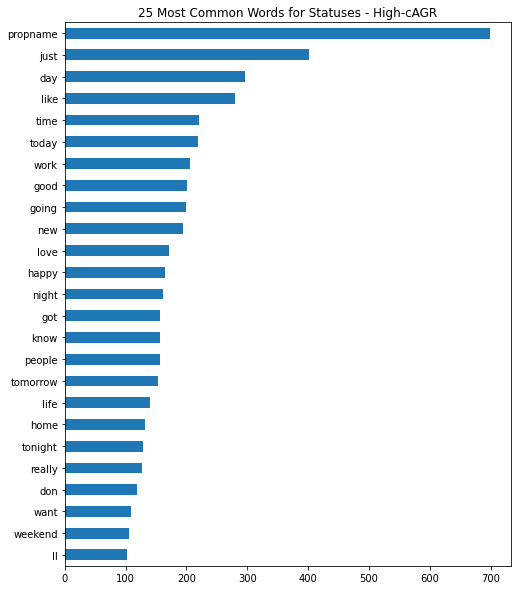

In [9]:
# Plot high cAGR
data_token_df[data_token_df['cAGR'] == 'y'].drop(columns=['cAGR'])\
    .sum().sort_values(ascending=False)[:25].sort_values()\
    .plot(kind='barh', figsize=(8, 10))
plt.title('25 Most Common Words for Statuses - High-cAGR');

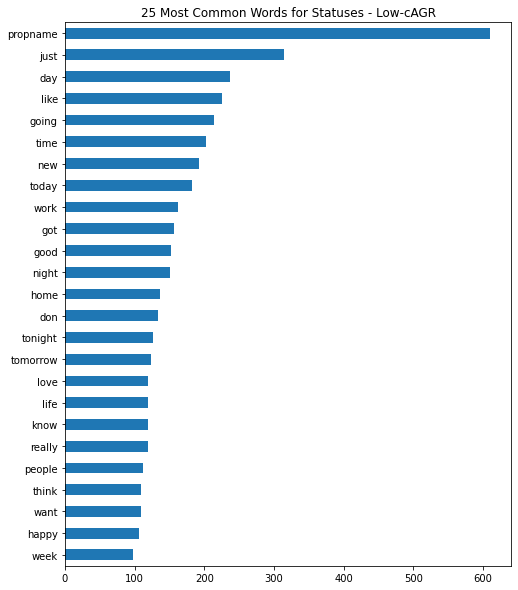

In [10]:
# Plot low cAGR
data_token_df[data_token_df['cAGR'] == 'n'].drop(columns=['cAGR'])\
    .sum().sort_values(ascending=False)[:25].sort_values()\
    .plot(kind='barh', figsize=(8, 10))
plt.title('25 Most Common Words for Statuses - Low-cAGR');

- No difference in top 20 common words

In [11]:
# Compare status length and word counts
data['status_length'] = data['STATUS'].str.len()
data['word_counts'] = data['STATUS'].apply(lambda x: len(x.split()))
data.groupby('cAGR')[['status_length', 'word_counts']].mean()

## No difference in both status length and word counts.b

,status_length,word_counts
cAGR,,
n,80.976769,14.616692
y,80.356492,14.444571


**5. What is the difference between CountVectorizer and TFIDFVectorizer?**

In [12]:
# CountVectorizer is a method to turn words to be numeric variables 
# by counting how many times each word appeared in a document.

# TFID is a method that will turn words to be numeric variables by giving a score for each word
# the score will be high if word occur in one document but not every document.
# And the score will be low if word commonly occur for every document.

**6. What are stopwords?**

In [13]:
# Stopwords are words that have no impact in terms of sentence's meaning if we exclude that words.
# Most of them are preposition and conjunction.

**7. Give an example of when you might remove stopwords.**

In [14]:
# If our determination is to classify who is our potential customer,
# stopwords might not be matter.

# Other case would be when we need to reduce data size, we can first remove
# less important information to our dataset.

**8. Give an example of when you might keep stopwords in your model.**

In [15]:
# When we conduct sentiment analysis, 'not' will play an important role to
# classify what actually customers' comentation would mean.

# Removing 'not' from words that we use to classify data will
# turn sentiment of word up side down.

### Step 4: Model the data.

We are going to fit two types of models: a logistic regression and [a Naive Bayes classifier](https://scikit-learn.org/stable/modules/naive_bayes.html).

**Reminder:** We will only use the feature `STATUS` to model `cAGR`.

### We want to attempt to fit our models on sixteen sets of features:

1. CountVectorizer with 100 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
2. CountVectorizer with 100 features, with English stopwords removed and with the default `ngram_range`.
3. CountVectorizer with 100 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
4. CountVectorizer with 100 features, with English stopwords kept in and with the default `ngram_range`.
5. CountVectorizer with 500 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
6. CountVectorizer with 500 features, with English stopwords removed and with the default `ngram_range`.
7. CountVectorizer with 500 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
8. CountVectorizer with 500 features, with English stopwords kept in and with the default `ngram_range`.
9. TFIDFVectorizer with 100 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
10. TFIDFVectorizer with 100 features, with English stopwords removed and with the default `ngram_range`.
11. TFIDFVectorizer with 100 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
12. TFIDFVectorizer with 100 features, with English stopwords kept in and with the default `ngram_range`.
13. TFIDFVectorizer with 500 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
14. TFIDFVectorizer with 500 features, with English stopwords removed and with the default `ngram_range`.
15. TFIDFVectorizer with 500 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
16. TFIDFVectorizer with 500 features, with English stopwords kept in and with the default `ngram_range`.

**9. Rather than manually instantiating 16 different vectorizers, what `sklearn` class have we learned about that might make this easier? Use it.**

In [16]:
# Create X, y
X = data['STATUS']
y = (data['cAGR'] == 'y').astype(int)

In [17]:
# Check class balance
y.value_counts(normalize=True).mul(100).round(2)

# No class imbalance problem.

1    53.12
0    46.88
Name: cAGR, dtype: float64

In [18]:
# Split train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [19]:
# Check split size
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7437,), (2480,), (7437,), (2480,))

In [20]:
# Define function to fit model using gridsearch
def model_grid(vecterizer, model, X_train, y_train):
    """Return fit gridsearch model by given parameters
    Parameters: vecterizer, model, X_train, y_train

    Set of hyperparameters that will be used:
    max_features = [100, 500]
    stop_words = [None, 'english']
    ngram_rang = [(1,1), (1,2)]"""
    pipe = Pipeline([
        ('vec', vecterizer),
        ('model', model)
    ])
    pipe_params = {
    'vec__max_features': [100, 500],
    'vec__stop_words': [None, 'english'],
    'vec__ngram_range': [(1,1), (1,2)]
    }
    grid = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
    return grid.fit(X_train, y_train)

# Define function to print scores
def print_scores(model):
    """Print best parameters, train and test accuracy for gridsearch model"""
    print(f'Best parameters: {model.best_params_}')
    print(f'Train score: {model.score(X_train, y_train).round(2)}')
    print(f'Test score: {model.score(X_test, y_test).round(2)}')

**10. What are some of the advantages of fitting a logistic regression model?**

In [21]:
# Fitting a logistic regression model will help us understand how
# words affect to likelihood of classification.

**11. Fit a logistic regression model and compare it to the baseline.**

In [22]:
# Baseline score
y.value_counts(normalize=True).mul(100).round(2)

## Baseline score will be the majority class which is 53.12% accuracy.

1    53.12
0    46.88
Name: cAGR, dtype: float64

In [23]:
# Fit logistic model
# CountVecterizer
logreg_cvec = model_grid(CountVectorizer(), LogisticRegression(random_state=42), X_train, y_train)
print_scores(logreg_cvec)

Best parameters: {'vec__max_features': 500, 'vec__ngram_range': (1, 1), 'vec__stop_words': 'english'}
Train score: 0.62
Test score: 0.54


In [24]:
# TFIDF
logreg_tfidf = model_grid(TfidfVectorizer(), LogisticRegression(random_state=42), X_train, y_train)
print_scores(logreg_tfidf)

Best parameters: {'vec__max_features': 500, 'vec__ngram_range': (1, 2), 'vec__stop_words': 'english'}
Train score: 0.63
Test score: 0.54


In [25]:
# Both CountVecterizer and TFIDF give the same scores for train and test dataset
# But the scores are very close to baseline score.

### Summary of Naive Bayes 

Naive Bayes is a classification technique that relies on probability to classify observations.
- It's based on a probability rule called **Bayes' Theorem**... thus, "**Bayes**."
- It makes an assumption that isn't often met, so it's "**naive**."

Despite being a model that relies on a naive assumption, it often performs pretty well! (This is kind of like linear regression... we aren't always guaranteed homoscedastic errors in linear regression, but the model might still do a good job regardless.)
- [Interested in details? Read more here if you want.](https://www.cs.unb.ca/~hzhang/publications/FLAIRS04ZhangH.pdf)


The [sklearn documentation](https://scikit-learn.org/stable/modules/naive_bayes.html) is here, but it can be intimidating. So, to quickly summarize the Bayes and Naive parts of the model...

#### Bayes' Theorem
If you've seen Bayes' Theorem, it relates the probability of $P(A|B)$ to $P(B|A)$. (Don't worry; we won't be doing any probability calculations by hand! However, you may want to refresh your memory on conditional probability from our earlier lessons if you forget what a conditional probability is.)

$$
\begin{eqnarray*}
\text{Bayes' Theorem: } P(A|B) &=& \frac{P(B|A)P(A)}{P(B)}
\end{eqnarray*}
$$

- Let $A$ be that someone is "agreeable," like the OCEAN category.
- Let $B$ represent the words used in their Facebook post.

$$
\begin{eqnarray*}
\text{Bayes' Theorem: } P(A|B) &=& \frac{P(B|A)P(A)}{P(B)} \\
\Rightarrow P(\text{person is agreeable}|\text{words in Facebook post}) &=& \frac{P(\text{words in Facebook post}|\text{person is agreeable})P(\text{person is agreeable})}{P(\text{words in Facebook post})}
\end{eqnarray*}
$$

We want to calculate the probability that someone is agreeable **given** the words that they used in their Facebook post! (Rather than calculating this probability by hand, this is done under the hood and we can just see the results by checking `.predict_proba()`.) However, this is exactly what our model is doing. We can (a.k.a. the model can) calculate the pieces on the right-hand side of the equation to give us a probability estimate of how likely someone is to be agreeable given their Facebook post.

#### Naive Assumption

If our goal is to estimate $P(\text{person is agreeable}|\text{words in Facebook post})$, that can be quite tricky.

---

<details><summary>Bonus: if you want to understand why that's complicated, click here.</summary>
    
- The event $\text{"words in Facebook post"}$ is a complicated event to calculate.

- If a Facebook post has 100 words in it, then the event $\text{"words in Facebook post"} = \text{"word 1 is in the Facebook post" and "word 2 is in the Facebook post" and }\ldots \text{ and "word 100 is in the Facebook post"}$.

- To calculate the joint probability of all 100 words being in the Facebook post gets complicated pretty quickly. (Refer back to the probability notes on how to calculate the joint probability of two events if you want to see more.)
</details>

---

To simplify matters, we make an assumption: **we assume that all of our features are independent of one another.**

In some contexts, this assumption might be realistic!

**12. Why would this assumption not be realistic with NLP data?**

In [26]:
# NLP is processing of transforming human languages such as text or voice to numuric variables
# that can feed to machine learning models.
# From Naive assumption that is "features have to be independent" but human languages will always
# be dependent as languages have sequences of words. For example: sentences.

Despite this assumption not being realistic with NLP data, we still use Naive Bayes pretty frequently.
- It's a very fast modeling algorithm. (which is great especially when we have lots of features and/or lots of data!)
- It is often an excellent classifier, outperforming more complicated models.

There are three common types of Naive Bayes models: Bernoulli Naive Bayes, Multinomial Naive Bayes, and Gaussian Naive Bayes.
- How do we pick which of the three models to use? It depends on our $X$ variable.
    - Bernoulli Naive Bayes is appropriate when our features are all 0/1 variables.
        - [Bernoulli NB Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB)
    - Multinomial Naive Bayes is appropriate when our features are variables that take on only positive integer counts.
        - [Multinomial NB Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)
    - Gaussian Naive Bayes is appropriate when our features are Normally distributed variables. (Realistically, though, we kind of use Gaussian whenever neither Bernoulli nor Multinomial works.)
        - [Gaussian NB Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)

**13. Suppose you CountVectorized your features. Which Naive Bayes model would be most appropriate to fit? Why? Fit it.**

In [27]:
# Fit Naive Bayes model
# CountVecterizer
nb_cvec = model_grid(CountVectorizer(), MultinomialNB(), X_train, y_train)
print_scores(nb_cvec)

Best parameters: {'vec__max_features': 500, 'vec__ngram_range': (1, 2), 'vec__stop_words': 'english'}
Train score: 0.61
Test score: 0.54


**14. Suppose you TFIDFVectorized your features. Which Naive Bayes model would be most appropriate to fit? Why? Fit it.**

In [28]:
# Fit Naive Bayes model
# TFIDF
nb_tfidf = model_grid(TfidfVectorizer(), MultinomialNB(), X_train, y_train)
print_scores(nb_tfidf)

Best parameters: {'vec__max_features': 500, 'vec__ngram_range': (1, 2), 'vec__stop_words': 'english'}
Train score: 0.62
Test score: 0.54


**15. Compare the performance of your models.**

In [29]:
def compare_models(models_list):
    """Return dataframe of models result from list of models"""
    df = pd.DataFrame(columns=['model', 'model_name', 'vectorizor', 'acc_train', 'acc_test'])
    for i in range(len(models_list)):
        df.loc[i] = [models_list[i],
                      str(models_list[i].get_params()['estimator__steps'][1][1]),
                      str(models_list[i].get_params()['estimator__steps'][0][1]),
                      models_list[i].score(X_train, y_train),
                      models_list[i].score(X_test, y_test)
                     ]
    return df

In [30]:
# Baseline score
y.value_counts(normalize=True).mul(100).round(2)

1    53.12
0    46.88
Name: cAGR, dtype: float64

In [31]:
compare_models([logreg_cvec, logreg_tfidf, nb_cvec, nb_tfidf])

,model,model_name,vectorizor,acc_train,acc_test
0,"GridSearchCV(cv=5,\n estimator=Pip...",LogisticRegression(random_state=42),CountVectorizer(),0.624042,0.540726
1,"GridSearchCV(cv=5,\n estimator=Pip...",LogisticRegression(random_state=42),TfidfVectorizer(),0.626866,0.542339
2,"GridSearchCV(cv=5,\n estimator=Pip...",MultinomialNB(),CountVectorizer(),0.609654,0.539516
3,"GridSearchCV(cv=5,\n estimator=Pip...",MultinomialNB(),TfidfVectorizer(),0.622294,0.541532


In [32]:
# As baseline score is 53.12%, our models from logistic regression and multinomial Naive Bayes
# best score for testing set is 54.23% accuracy.
# Which means our models still not beat a beaseline score.
# Then, it would imply that the features, which are statuses, are not enough to classify the personality.
# Or the models are not tuned well enough.

**16. Even though we didn't explore the full extent of Cambridge Analytica's modeling, based on what we did here, how effective was their approach at using Facebook data to model agreeableness?**

In [33]:
# In my opnion, from the result, only Facebook statuses would not be enough to classify personalities.
# But I also think that some digital footprints on Facebook that we could not captured this time
# might have some useful signal for personality classification.